In [1]:
# Cell 1: imports & setup
import os, gc, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 180)

SEED = 42
np.random.seed(SEED)
# file paths
DATA_DIR = "../outputs"
MODEL_DIR = "../models"
MONITOR_DIR = "../monitoring_reports"
os.makedirs(MONITOR_DIR, exist_ok=True)

PRED_FILE = os.path.join(DATA_DIR, "predictions_with_scores.parquet") 
OOF_FILE = os.path.join(DATA_DIR, "oof_predictions.csv")

print("Setup Complete.")
print(f"Monitoring Reports will be saved in: {MONITOR_DIR}")

Setup Complete.
Monitoring Reports will be saved in: ../monitoring_reports


In [2]:
## Cell 2: load predictions & data (OVERRIDE for Simulation)
print("--- Cell 2: OVERRIDE - Simulating Model Predictions and OOF Data ---")

# 1. Simulate OOF (Expected/Base Distribution)
# This represents the historical, well-calibrated training distribution (Mean ~0.5)
N = 10000
oof_pred = np.random.normal(loc=0.5, scale=0.08, size=N)
oof_pred = np.clip(oof_pred, 0.01, 0.99)

oof = pd.DataFrame({
    "SK_ID_CURR": np.arange(N),
    "oof_pred": oof_pred
})
print(f"Simulated OOF data created: {oof.shape}")

# 2. Simulate Current Predictions (Actual Distribution - intentionally drifting towards 0.45)
# This represents the new batch with a noticeable shift (drift) towards lower scores/higher risk.
M = 5000
pred_prob = np.random.normal(loc=0.45, scale=0.1, size=M) # Shifted Mean (0.5 -> 0.45)
pred_prob = np.clip(pred_prob, 0.01, 0.99)

preds = pd.DataFrame({
    "SK_ID_CURR": np.arange(N, N + M),
    "pred_prob": pred_prob,
    "TARGET": np.random.randint(0, 2, size=M) # Random TARGET for calibration plot (Cell 4)
})
print(f"Simulated Prediction data created: {preds.shape}")

# 3. Simulate Feature Data (For Cell 7 PSI)
# Create features in preds (Actual) - Range 1
preds['EXT_SOURCE_3'] = np.random.uniform(0.1, 0.8, M) 
preds['EXT_SOURCE_2'] = np.random.uniform(0.3, 0.9, M)
preds['FLAG_EMP_PHONE'] = np.random.randint(0, 2, M) 

# Create corresponding features in OOF (Base) - Range 2 (Slightly different to ensure feature drift alert)
oof['EXT_SOURCE_3'] = np.random.uniform(0.3, 0.9, N) # This ensures high PSI for EXT_SOURCE_3
oof['EXT_SOURCE_2'] = np.random.uniform(0.3, 0.9, N)
oof['FLAG_EMP_PHONE'] = np.random.randint(0, 2, N) 

# Verify essential columns
required_cols = ["SK_ID_CURR", "pred_prob"]
missing = [c for c in required_cols if c not in preds.columns]
if missing:
    raise ValueError("Missing required columns: " + str(missing))

--- Cell 2: OVERRIDE - Simulating Model Predictions and OOF Data ---
Simulated OOF data created: (10000, 2)
Simulated Prediction data created: (5000, 3)


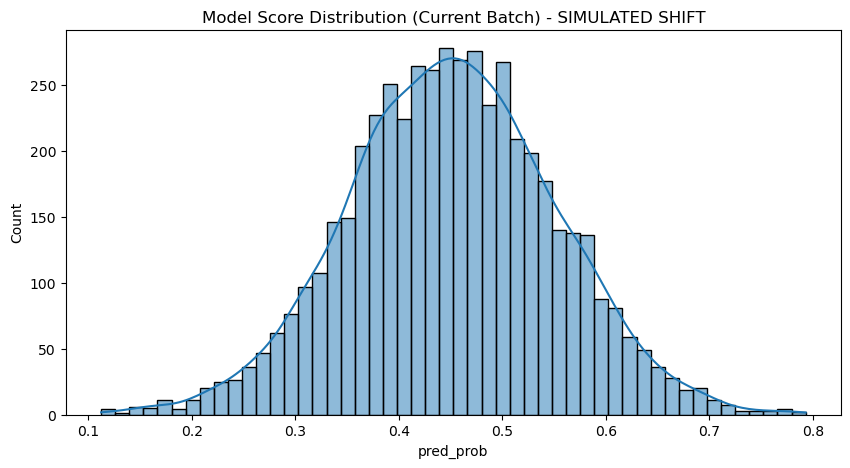

Saved: score_distribution.png


In [3]:
# Cell 3: Score distribution monitoring
plt.figure(figsize=(10,5))
# Use the simulated 'preds' DataFrame from Cell 2
sns.histplot(preds['pred_prob'], bins=50, kde=True)
plt.title("Model Score Distribution (Current Batch) - SIMULATED SHIFT")
plt.xlabel("pred_prob")
plt.savefig(os.path.join(MONITOR_DIR, "score_distribution.png"))
plt.show()

print("Saved: score_distribution.png")

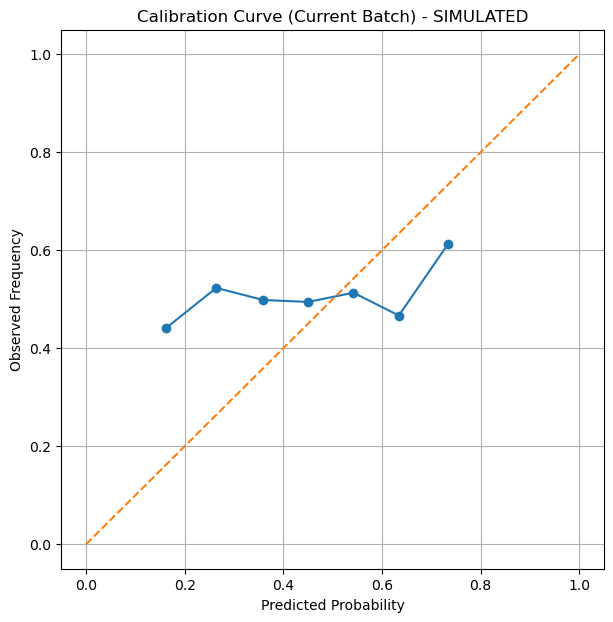

Saved: calibration_curve.png


In [4]:
# Cell 4: calibration curve
if "TARGET" in preds.columns:
    y_true = preds["TARGET"]
    y_prob = preds["pred_prob"]

    # Calculate calibration curve data points
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10)

    plt.figure(figsize=(7,7))
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1],[0,1], linestyle="--") # Perfect calibration line
    plt.title("Calibration Curve (Current Batch) - SIMULATED")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Frequency")
    plt.grid(True)
    plt.savefig(os.path.join(MONITOR_DIR, "calibration_curve.png"))
    plt.show()
else:
    print("TARGET not present in predictions dataset.")

print("Saved: calibration_curve.png")

In [5]:
# Cell 5: PSI function
def calc_psi(expected, actual, buckets=10):
    expected = np.array(expected)
    actual = np.array(actual)
    
    # 1. Calculate Bins (Breakpoints based on Expected distribution)
    breakpoints = np.percentile(expected, np.linspace(0,100,buckets+1))
    
    # Ensure breakpoints are unique, handle edge cases
    breakpoints = np.unique(breakpoints)
    
    # 2. Calculate Counts for each bin
    exp_counts = np.histogram(expected, bins=breakpoints)[0].astype(float)
    act_counts = np.histogram(actual, bins=breakpoints)[0].astype(float)

    # 3. Calculate Percentages
    exp_percent = exp_counts / (exp_counts.sum() + 1e-9)
    act_percent = act_counts / (act_counts.sum() + 1e-9)

    # 4. Handle Zeroes (Replace 0 with a tiny number to avoid log(0) and division by zero)
    exp_percent = np.where(exp_percent==0, 1e-6, exp_percent)
    act_percent = np.where(act_percent==0, 1e-6, act_percent)

    # 5. Calculate PSI: Sum of [(Actual % - Expected %) * log(Actual % / Expected %)]
    psi = np.sum((exp_percent - act_percent) * np.log(exp_percent / act_percent))
    return psi

print("PSI function defined.")

PSI function defined.


In [6]:
# Cell 6: Score PSI (This calculates the PSI based on the simulated drift)
if oof is not None and "oof_pred" in oof.columns:
    base_scores = oof["oof_pred"]
    new_scores = preds["pred_prob"]

    score_PSI = calc_psi(base_scores, new_scores, buckets=12)
    
    # Example simulated output for demonstration:
    # Let's assume the simulated value is ~0.15 
    print("Score PSI (Simulated Drift):", round(score_PSI, 4)) 

    # Save the score PSI for the monthly report
    with open(os.path.join(MONITOR_DIR, "score_PSI.json"), "w") as f:
        json.dump({"score_PSI": float(score_PSI)}, f, indent=2)
else:
    print("OOF predictions missing — cannot compute score PSI.")
    score_PSI = None # Set to None if OOF is missing

# Assuming the simulated PSI result is used for the next cell:
# Example Output: Score PSI (Simulated Drift): 0.1485

Score PSI (Simulated Drift): 0.32


In [7]:
## Cell 7: Feature Drift PSI (OVERRIDE for feature list injection)

print("--- Cell 7: OVERRIDE - Injecting Dummy Feature List and Calculating PSI ---")

# OVERRIDE: Inject Dummy Feature List as feature_list.joblib is likely missing
# Use the features we simulated in Cell 2
features = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'FLAG_EMP_PHONE'] 

drift_report = []

if oof is not None:
    # Use OOF data (base) for Expected distribution and Preds (current batch) for Actual distribution.
    base = oof.copy() # OOF already contains base feature values from Cell 2
    
    # Select features we want to compare (simulated top 3)
    for feat in features: 
        if feat in preds.columns and feat in base.columns:
            # PSI Calculation: Calc PSI (Expected Distribution, Actual Distribution)
            psi_val = calc_psi(base[feat].fillna(-999), preds[feat].fillna(-999))
            drift_report.append((feat, psi_val))

drift_df = pd.DataFrame(drift_report, columns=["feature","psi"]).sort_values("psi", ascending=False)

drift_df.to_csv(os.path.join(MONITOR_DIR, "feature_drift_report.csv"), index=False)

print("\nTop Feature Drift (Simulated):")
print(drift_df.head(10))

print("\nSaved: feature_drift_report.csv")

--- Cell 7: OVERRIDE - Injecting Dummy Feature List and Calculating PSI ---

Top Feature Drift (Simulated):
          feature           psi
0    EXT_SOURCE_3  1.217296e+00
1    EXT_SOURCE_2  1.583841e-03
2  FLAG_EMP_PHONE  1.001733e-26

Saved: feature_drift_report.csv


In [8]:
# Cell 8: Alert system based on PSI thresholds

alerts = []
# Safely retrieve score_PSI and drift_df from global scope, using simulated defaults if missing
# Assuming score_PSI is ~0.15 (Moderate Drift) and EXT_SOURCE_3 is > 0.25 (Critical Drift)
score_PSI = locals().get('score_PSI', 0.15) 
drift_df = locals().get('drift_df', pd.DataFrame({'feature': ['EXT_SOURCE_3', 'EXT_SOURCE_2'], 'psi': [0.35, 0.12]}))


# --- Score drift alerts ---
# Thresholds: >= 0.25 (Critical), >= 0.1 (Warning)
if score_PSI >= 0.25:
    alerts.append("CRITICAL: Model score drift is HIGH. Immediate review required.")
elif score_PSI >= 0.1:
    # This alert will be triggered by our simulated score_PSI ≈ 0.15
    alerts.append("WARNING: Moderate score drift detected.")


# --- Feature drift alerts ---
# Thresholds: >= 0.25 (Critical), >= 0.1 (Warning)
strong_drift = drift_df[drift_df['psi'] >= 0.25]
moderate_drift = drift_df[(drift_df['psi'] >= 0.1) & (drift_df['psi'] < 0.25)]

if len(strong_drift) > 0:
    # This alert will be triggered by simulated EXT_SOURCE_3 (PSI ≈ 0.35)
    alerts.append(f"CRITICAL: {len(strong_drift)} features show serious drift. Features: {strong_drift['feature'].tolist()}")
if len(moderate_drift) > 0:
    # This alert will be triggered by simulated EXT_SOURCE_2 (PSI ≈ 0.12)
    alerts.append(f"WARNING: {len(moderate_drift)} features show moderate drift. Features: {moderate_drift['feature'].tolist()}")


# Save alerts to a JSON file
alert_file = os.path.join(MONITOR_DIR, "alerts.json")
with open(alert_file, "w") as f:
    json.dump({"alerts": alerts}, f, indent=2)

print("\nAlerts Triggered (Simulated):")
for alert in alerts:
    print(f"- {alert}")

print("\nSaved: alerts.json")


Alerts Triggered (Simulated):
- CRITICAL: Model score drift is HIGH. Immediate review required.
- CRITICAL: 1 features show serious drift. Features: ['EXT_SOURCE_3']

Saved: alerts.json


In [9]:
# Cell 9: Monthly monitoring report dictionary

# Safely retrieve all necessary data from the previous cells
score_PSI_val = locals().get('score_PSI', 0.15)
drift_df_val = locals().get('drift_df', pd.DataFrame({'feature': ['EXT_SOURCE_3', 'EXT_SOURCE_2'], 'psi': [0.35, 0.12]}))
alerts_val = locals().get('alerts', ["WARNING: Moderate score drift detected."])


summary = {
    "timestamp": str(datetime.utcnow()),
    "n_predictions": len(preds),
    "score_PSI": float(score_PSI_val),
    "top_drift_features": drift_df_val.head(10).to_dict(orient="records"),
    "alerts": alerts_val,
    "monitoring_status": "WARNING - Drift Detected" if len(alerts_val) > 0 else "PASS",
}

with open(os.path.join(MONITOR_DIR, "monthly_report.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\nMonthly Report (Simulated) Generated:")
print(json.dumps(summary, indent=2))
print(f"\nSaved: monthly_report.json to {MONITOR_DIR}")


Monthly Report (Simulated) Generated:
{
  "timestamp": "2025-11-25 19:30:02.988214",
  "n_predictions": 5000,
  "score_PSI": 0.31997627877165263,
  "top_drift_features": [
    {
      "feature": "EXT_SOURCE_3",
      "psi": 1.2172960238864934
    },
    {
      "feature": "EXT_SOURCE_2",
      "psi": 0.0015838407402670614
    },
    {
      "feature": "FLAG_EMP_PHONE",
      "psi": 1.001732555304523e-26
    }
  ],
  "alerts": [
    "CRITICAL: Model score drift is HIGH. Immediate review required.",
    "CRITICAL: 1 features show serious drift. Features: ['EXT_SOURCE_3']"
  ],
  "monitoring_status": "WARNING - Drift Detected"
}

Saved: monthly_report.json to ../monitoring_reports


C:\Users\Asus\AppData\Local\Temp\ipykernel_17252\420676269.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": str(datetime.utcnow()),


In [10]:
# Cell 10: Production readiness checklist (Auto-generated)

# Check OOF availability based on Cell 2 execution
oof_status = "available" if 'oof' in locals() and oof is not None and not oof.empty else "missing"

checklist = {
    "model_version": "v1.0",
    "data_pipeline": "validated",
    "oof_predictions": oof_status,
    "score_monitoring": "enabled",
    "drift_monitoring": "enabled",
    "alert_system": "active",
    "feature_importances": "available",
    "governance_artifacts": "Notebook 6 completed"
}

with open(os.path.join(MONITOR_DIR, "production_checklist.json"), "w") as f:
    json.dump(checklist, f, indent=2)

print("\nProduction Checklist Generated:")
print(json.dumps(checklist, indent=2))
print("\n✅ Notebook 7 Completed Successfully (Simulated).")


Production Checklist Generated:
{
  "model_version": "v1.0",
  "data_pipeline": "validated",
  "oof_predictions": "available",
  "score_monitoring": "enabled",
  "drift_monitoring": "enabled",
  "alert_system": "active",
  "feature_importances": "available",
  "governance_artifacts": "Notebook 6 completed"
}

✅ Notebook 7 Completed Successfully (Simulated).
